In [252]:
import numpy as np
import pandas as pd
weight = 0.7
bias = 0.3
start = 0
stop = 1
step = 0.02
x = np.arange(start, stop, step)
y = weight * x + bias
data = {'x': x,
        'y': y
}
frame = pd.DataFrame(data)
frame.head()

,x,y
0,0.00,0.300
1,0.02,0.314
2,0.04,0.328
3,0.06,0.342
4,0.08,0.356


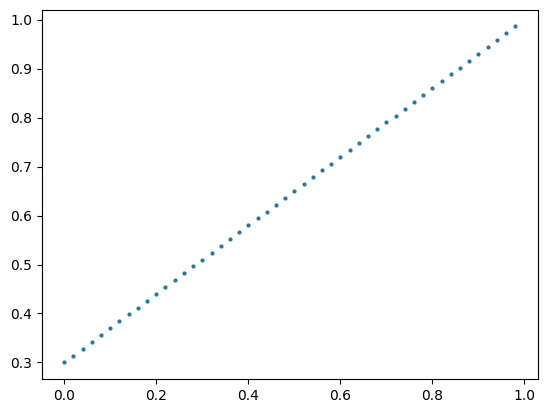

In [253]:
import matplotlib.pyplot as plt
plt.scatter(x, y, 4)

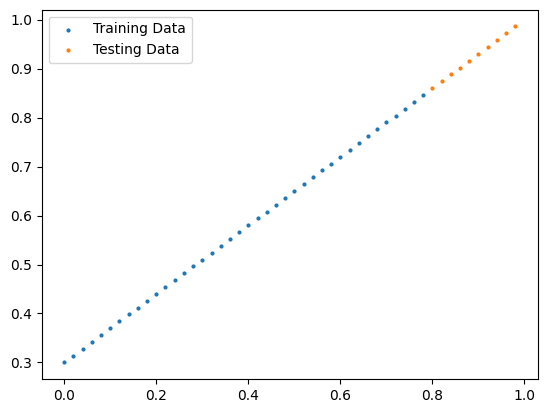

In [254]:
import torch
trainingSplit = int(0.8 * len(x))
XTrain = x[:trainingSplit]
yTrain = y[:trainingSplit]
XTest = x[trainingSplit:]
yTest = y[trainingSplit:]
data = [XTrain, yTrain, XTest, yTest]
for i, arr in enumerate(data):
    # We need to turn the data into tensors so we can use PyTorch functions on the data.
    data[i] = torch.from_numpy(arr).to(torch.float).unsqueeze(1)
XTrain, yTrain, XTest, yTest = data
plt.scatter(XTrain, yTrain, 4, label='Training Data')
plt.scatter(XTest, yTest, 4, label='Testing Data')
plt.legend()

In PyTorch's torch.nn there is a class called Linear that provides a weight and a bias. The formula for a linear function is y = xA + b, where A is the weight and b is the bias.

In [255]:
from torch import nn
model = nn.Linear(1, 1)
weight, bias, model.state_dict()

(0.7,
 0.3,
 OrderedDict([('weight', tensor([[0.1650]])), ('bias', tensor([0.3295]))]))

In [256]:
initialWeight = model.state_dict()['weight']
XTest, initialWeight, XTest.shape, initialWeight.shape

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.1650]]),
 torch.Size([10, 1]),
 torch.Size([1, 1]))

We can't do matrix multiplication unless the second dimension of the first matrix is the same as the first dimension of the second matrix. The first matrix is the tensor of x-values and the second matrix is the weight. Thus we needed to make the shape of the tensor end in a 1. PyTorch has a function called unsqueeze that adds a dimension of size 1 at the specified position. Instead of containing numbers, the tensor now contains tensors that each have 1 number.

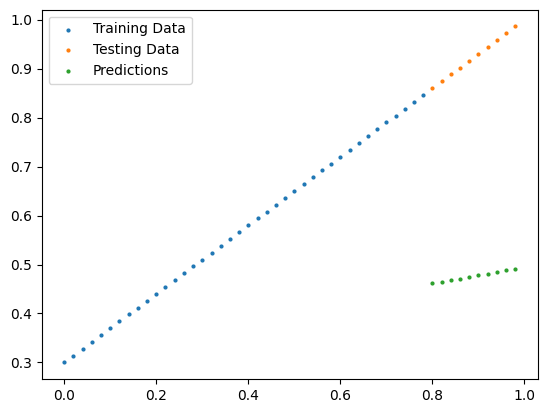

In [257]:
def predict_and_plot():
    # turns off requires grad which matplotlib doesn't like
    with torch.inference_mode():
        yPredictions = model(XTest)
    plt.scatter(XTrain, yTrain, 4, label='Training Data')
    plt.scatter(XTest, yTest, 4, label='Testing Data')
    plt.scatter(XTest, yPredictions, 4, label='Predictions')
    plt.legend()
predict_and_plot()

The loss function measures the mean absolute error between the model's predictions and the actual data. Mean absolute error is the average distance between the prediction and the true value. It is calculated as the sum of all the absolute values of each prediction minus each true value divided by the number of predictions.
The optimizer is what changes the parameters of a function. This optimizer uses stochastic gradient descent (SGD). SGD has a parameter lr which is the learning rate.

In [258]:
lossFun = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 2000
lossArray = np.array([])
testLossArray = np.array([])
for epoch in range(epochs):
    # turns on train mode
    model.train()
    # make predictions
    yPredictions = model(XTrain)
    # calculatethe loss
    loss = lossFun(yPredictions, yTrain)
    # make the model better
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # turns off train mode
    model.eval()
    # see how well the model does now
    with torch.inference_mode():
        testPredictions = model(XTest)
        testLoss = lossFun(testPredictions, yTest)
    # record the data
    lossArray = np.append(lossArray, loss.item())
    testLossArray = np.append(testLossArray, testLoss.item())
data = {
    "loss": lossArray,
    "test loss": testLossArray
}
pd.DataFrame(data)

,loss,test loss
0,0.182009,0.434749
1,0.173591,0.423332
2,0.165905,0.412450
3,0.158891,0.402112
4,0.152584,0.391775
...,...,...
1995,0.004574,0.004376
1996,0.006947,0.009095
1997,0.004574,0.004376
1998,0.006947,0.009095


In [259]:
weight, bias, model.state_dict()

(0.7,
 0.3,
 OrderedDict([('weight', tensor([[0.6949]])), ('bias', tensor([0.3090]))]))

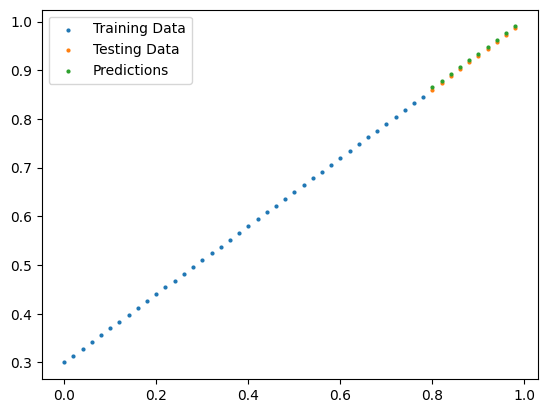

In [260]:
predict_and_plot()